In [148]:
import numpy as np
import seaborn as sns
import pymc3 as pm
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cd ./ont_data_test

[Errno 2] No such file or directory: './ont_data_test'
/home/jgs/jupyter/ont_data_test


In [3]:
ts = pd.read_table('flipDataFinal.txt', names=['current'])

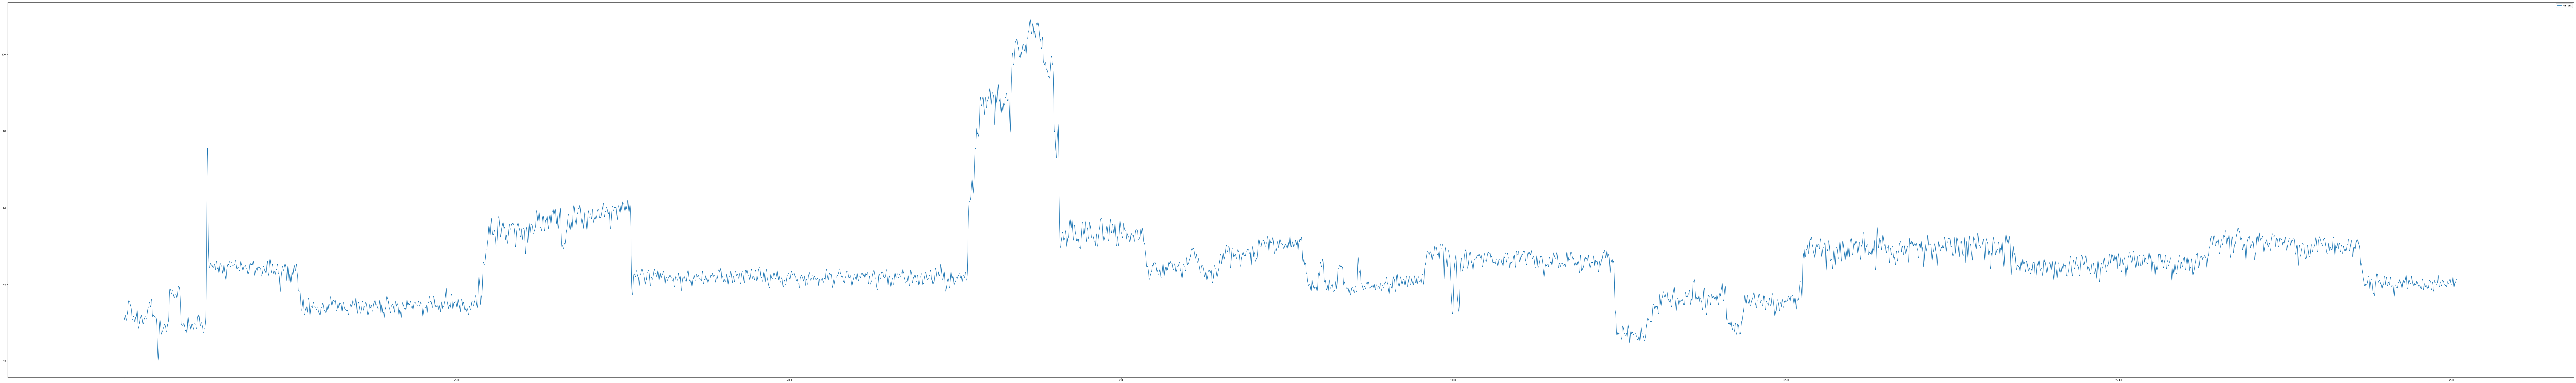

In [4]:
ts.plot(figsize=(200, 30));

In [203]:
def switch_test(current, mu_p, sd_p,sample_num=1000, threads=4):
    with pm.Model() as switch_point:
        #sps = pm.Poisson('points', 0)
        #ragnes = np.random.randint(years.min(),years.max(), sps)
        current_data = current[0]
        time = current[1]
        switchpoint = pm.DiscreteUniform('switchpoint', lower=time.min(), upper=time.max())

        # Priors for pre- and post-switch rates number of disasters
        early_rate = pm.Normal('early_rate', mu=mu_p, sd=sd_p)
        late_rate = pm.Normal('late_rate', mu=mu_p, sd=sd_p)

        # Allocate appropriate Poisson rates to years before and after current
        rate = pm.math.switch(switchpoint >= time, early_rate, late_rate)

        disasters = pm.Normal('current', mu=rate, sd=70, observed=current_data)
        if sample_num > 5000:
            trace = pm.sample(5000, cores=threads)
        elif sample_num < 200:
            trace = pm.sample(200, cores=threads)
        else:
            trace = pm.sample(sample_num, cores=threads)
            
    return [trace['switchpoint'].mean(), trace['switchpoint'].std(),
            [trace['early_rate'].mean(), trace['early_rate'].std()],
            [trace['late_rate'].mean(), trace['late_rate'].std()]]

In [192]:
ts_n = (ts-ts.mean())/ts.std()
ts_e = ts_n*70 + 400
tr = ts_e.rolling(window=10, center=True, min_periods=1)
tss = tr.mean()[::5]
tsv = tr.var()

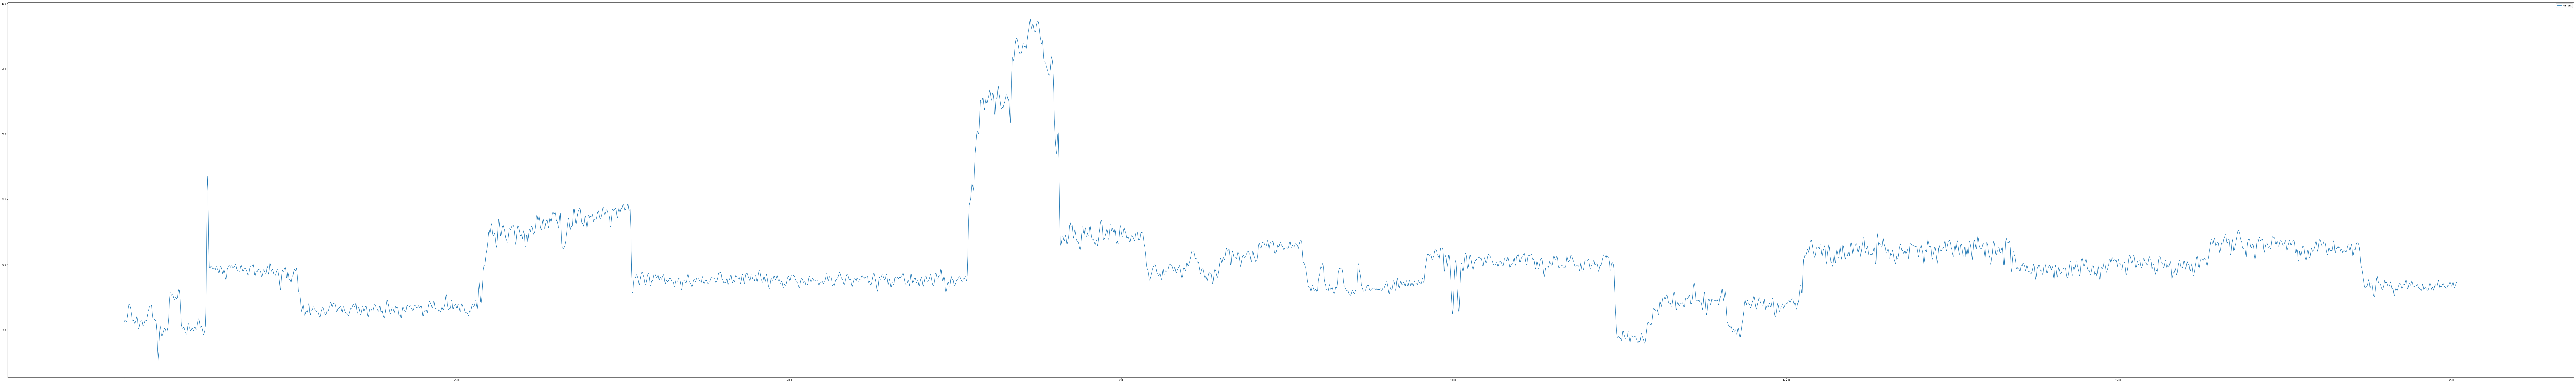

In [193]:
tss.plot(figsize=(200, 30));

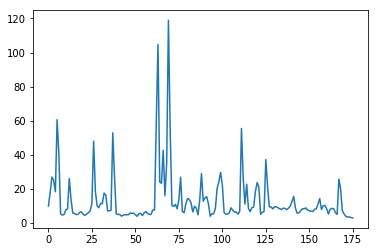

In [237]:
size_r = 20
cut_r = [[tss[i:i+2*size_r].values.T, np.array(tss[i:i+2*size_r].index)] for i in range(0, len(tss),size_r)]
def region(df, vc=10, size=size_r):
    if np.std(df[0]) > vc:
        size_r = 10
        tmp = [[df[i:i+2*size_r].values.T, np.array(df[i:i+2*size_r].index)] for i in range(0, len(df),size_r)]
        for i in tmp:
            return switch_test(i, 40, 20, size_r)
    else:
        return switch_test(i, 40, 20, size)
plt.plot([np.std(i[0]) for i in cut_r])
#test_r = [switch_test(i, 40, 20) for i in cut_r];
#test_r = [region(i) for i in cut_r];

In [149]:
#tss[500:1000]

In [207]:
size_r = 50
cut_r = [[tss[i:i+2*size_r].values.T, np.array(tss[i:i+2*size_r].index)] for i in range(0, len(tss),size_r)]
test_r = [switch_test(i, 400, 70) for i in cut_r];

INFO (theano.gof.compilelock): Refreshing lock /home/jgs/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-stretch-sid-x86_64-3.7.1-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2661.30draws/s]
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6254074840154978, but should be close to 0.8. Try to increase the number of tuning steps.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5884610083027134, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for

In [238]:
size_r = 30
cut_r = [tss[i:i+2*size_r] for i in range(0, len(tss) ,size_r)]
def region(df, size=20, vc=20):
    if df.std().values > vc:
        size_r = size//2
        tmp = [[df[i:i+2*size_r].values.T, np.array(df[i:i+2*size_r].index)] for i in range(0, len(df),size_r)]
        for i in tmp:
            return switch_test(i, 400, 70, size_r)
    else:
        df = [df.values.T, np.array(df.index)]
        return switch_test(df, 400, 70, size)
#[np.std(i[0]) for i in cut_r]
#test_r = [switch_test(i, 40, 20) for i in cut_r];
print(len(cut_r))
test_r = [region(i, 30, 10) for i in cut_r];

INFO (theano.gof.compilelock): Refreshing lock /home/jgs/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-stretch-sid-x86_64-3.7.1-64/lock_dir/lock


117


Only 200 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 4 chains: 100%|██████████| 2800/2800 [00:01<00:00, 2611.71draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Only 200 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 4 chains: 100%|██████████| 2800/2800 [00:01<00:00, 2635.32draws/s]
The acceptance probability does not match the target. It is 0.6823378761846501, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Only 200 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate, ear

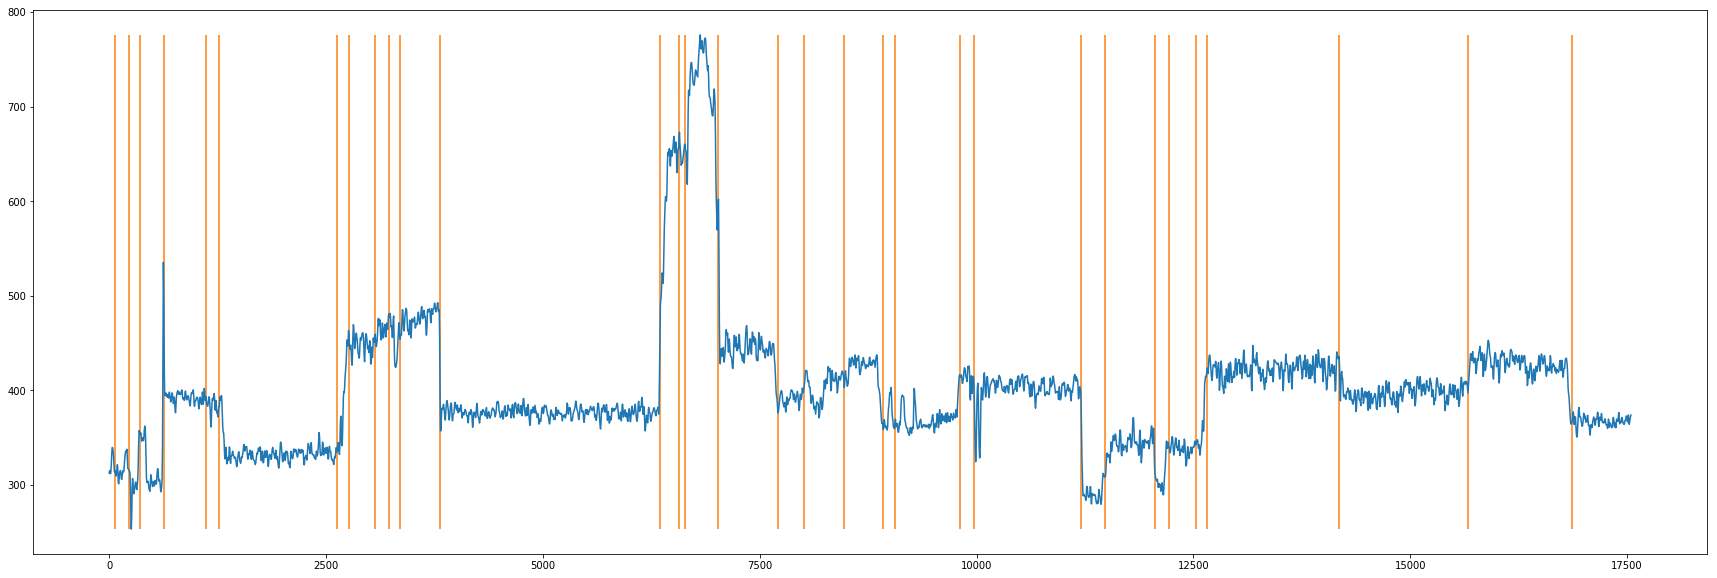

In [253]:
cutoff = 50; pc = 0.5
vl_r = [i[0] for i in test_r if (i[1] < cutoff and sp.stats.ttest_ind_from_stats(i[2][0],i[2][1],20, i[3][0],i[3][1],20).pvalue < pc)]
vs_r = [i[1] for i in test_r if (i[1] < cutoff and sp.stats.ttest_ind_from_stats(i[2][0],i[2][1],20, i[3][0],i[3][1],20).pvalue < pc)]
plt.figure(figsize=(30, 10))
plt.plot(tss)
plt.vlines(vl_r, tss.min(), tss.max(), color='C1')
for i in [i for i in test_r if i[1] < (i[1] < cutoff and sp.stats.ttest_ind_from_stats(i[2][0],i[2][1],20, i[3][0],i[3][1],20).pvalue < pc)]:
    plt.fill_betweenx(y=[int(tss.min()), int(tss.max())], x1=i[0] - i[1], x2=i[0] + i[1], alpha=0.5, color='C1');

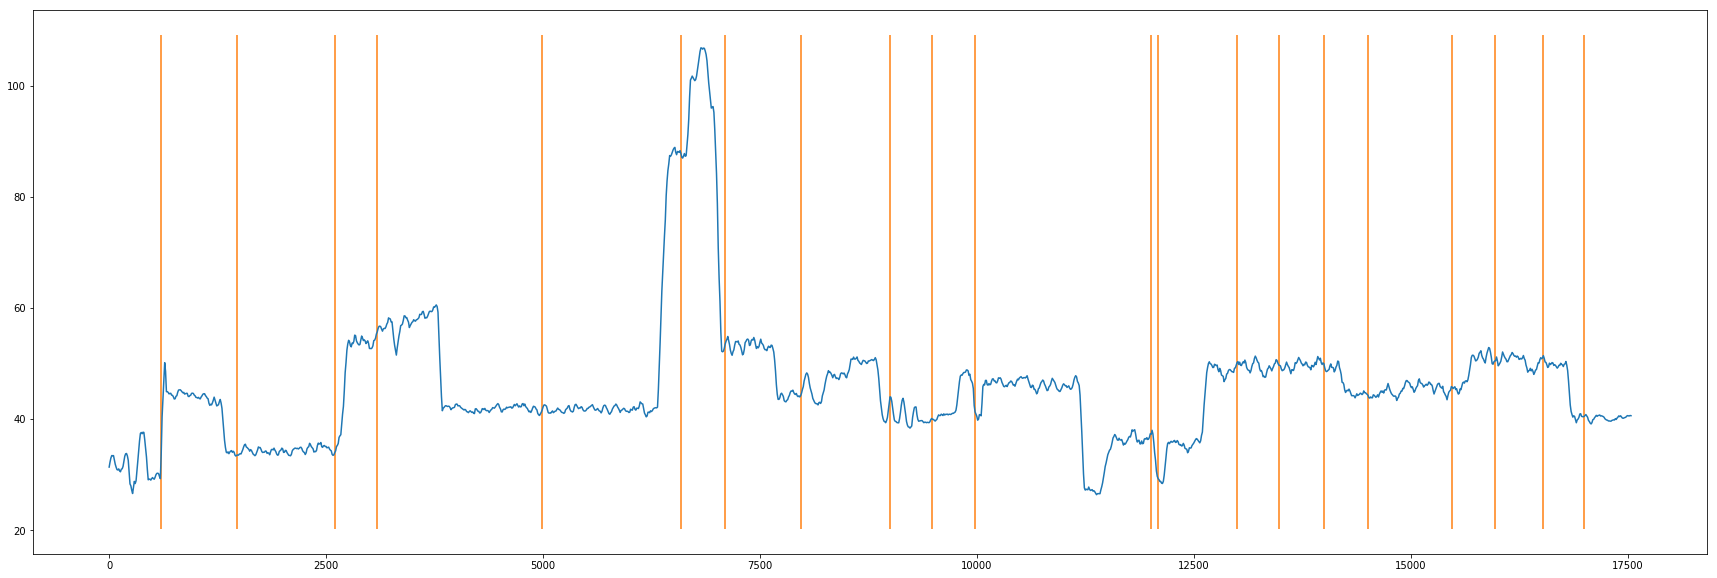

In [62]:
cutoff = 10000; pc = 0.9
vl_r = [i[0] for i in test_r if (i[1] < cutoff and sp.stats.ttest_ind_from_stats(i[2][0],i[2][1],20, i[3][0],i[3][1],20).pvalue < pc)]
vs_r = [i[1] for i in test_r if (i[1] < cutoff and sp.stats.ttest_ind_from_stats(i[2][0],i[2][1],20, i[3][0],i[3][1],20).pvalue < pc)]
plt.figure(figsize=(30, 10))
plt.plot(tss)
plt.vlines(vl_r, ts.min(), ts.max(), color='C1')
for i in [i for i in test_r if i[1] < (i[1] < cutoff and sp.stats.ttest_ind_from_stats(i[2][0],i[2][1],20, i[3][0],i[3][1],20).pvalue < pc)]:
    plt.fill_betweenx(y=[int(tss.min()), int(tss.max())], x1=i[0] - i[1], x2=i[0] + i[1], alpha=0.5, color='C1');

In [122]:
tr = ts.rolling(window=30, center=True, min_periods=1)
tss = tr.mean()
tsv = tr.var()

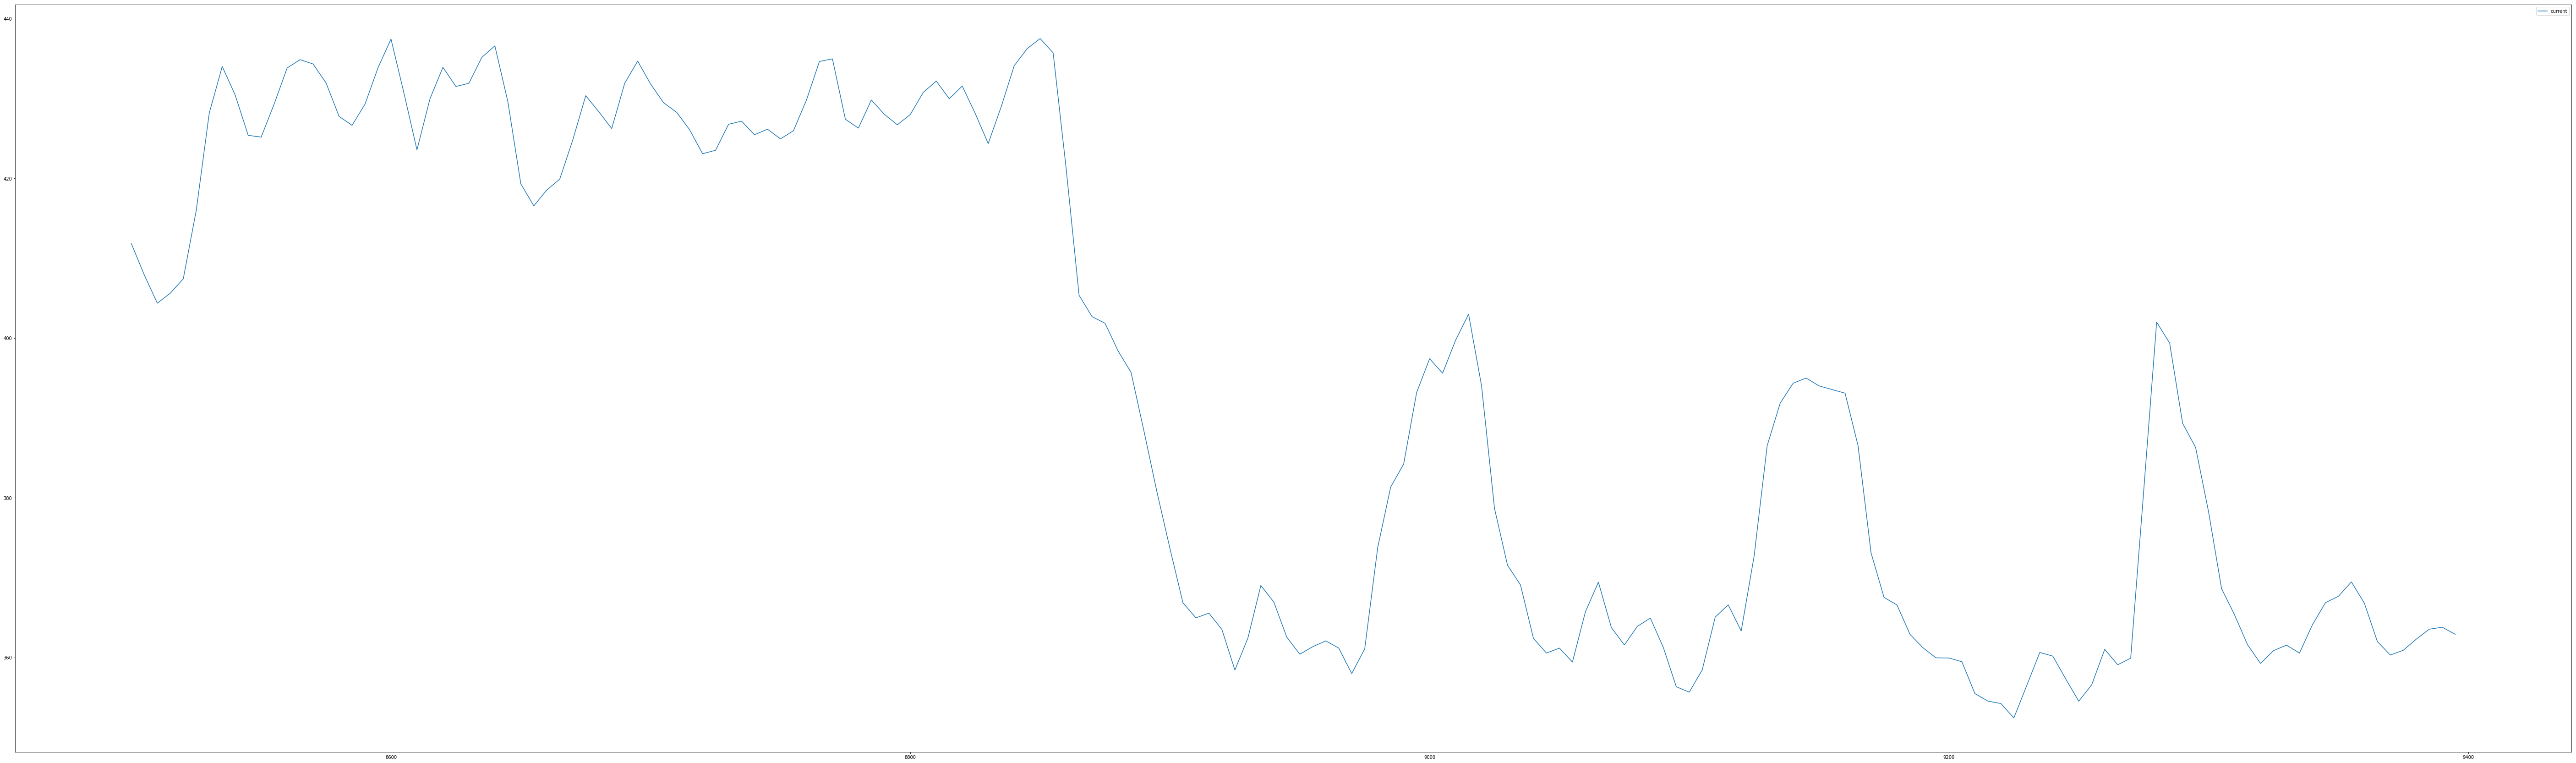

In [196]:
tss[850*2:940*2].plot(figsize=(100, 30));

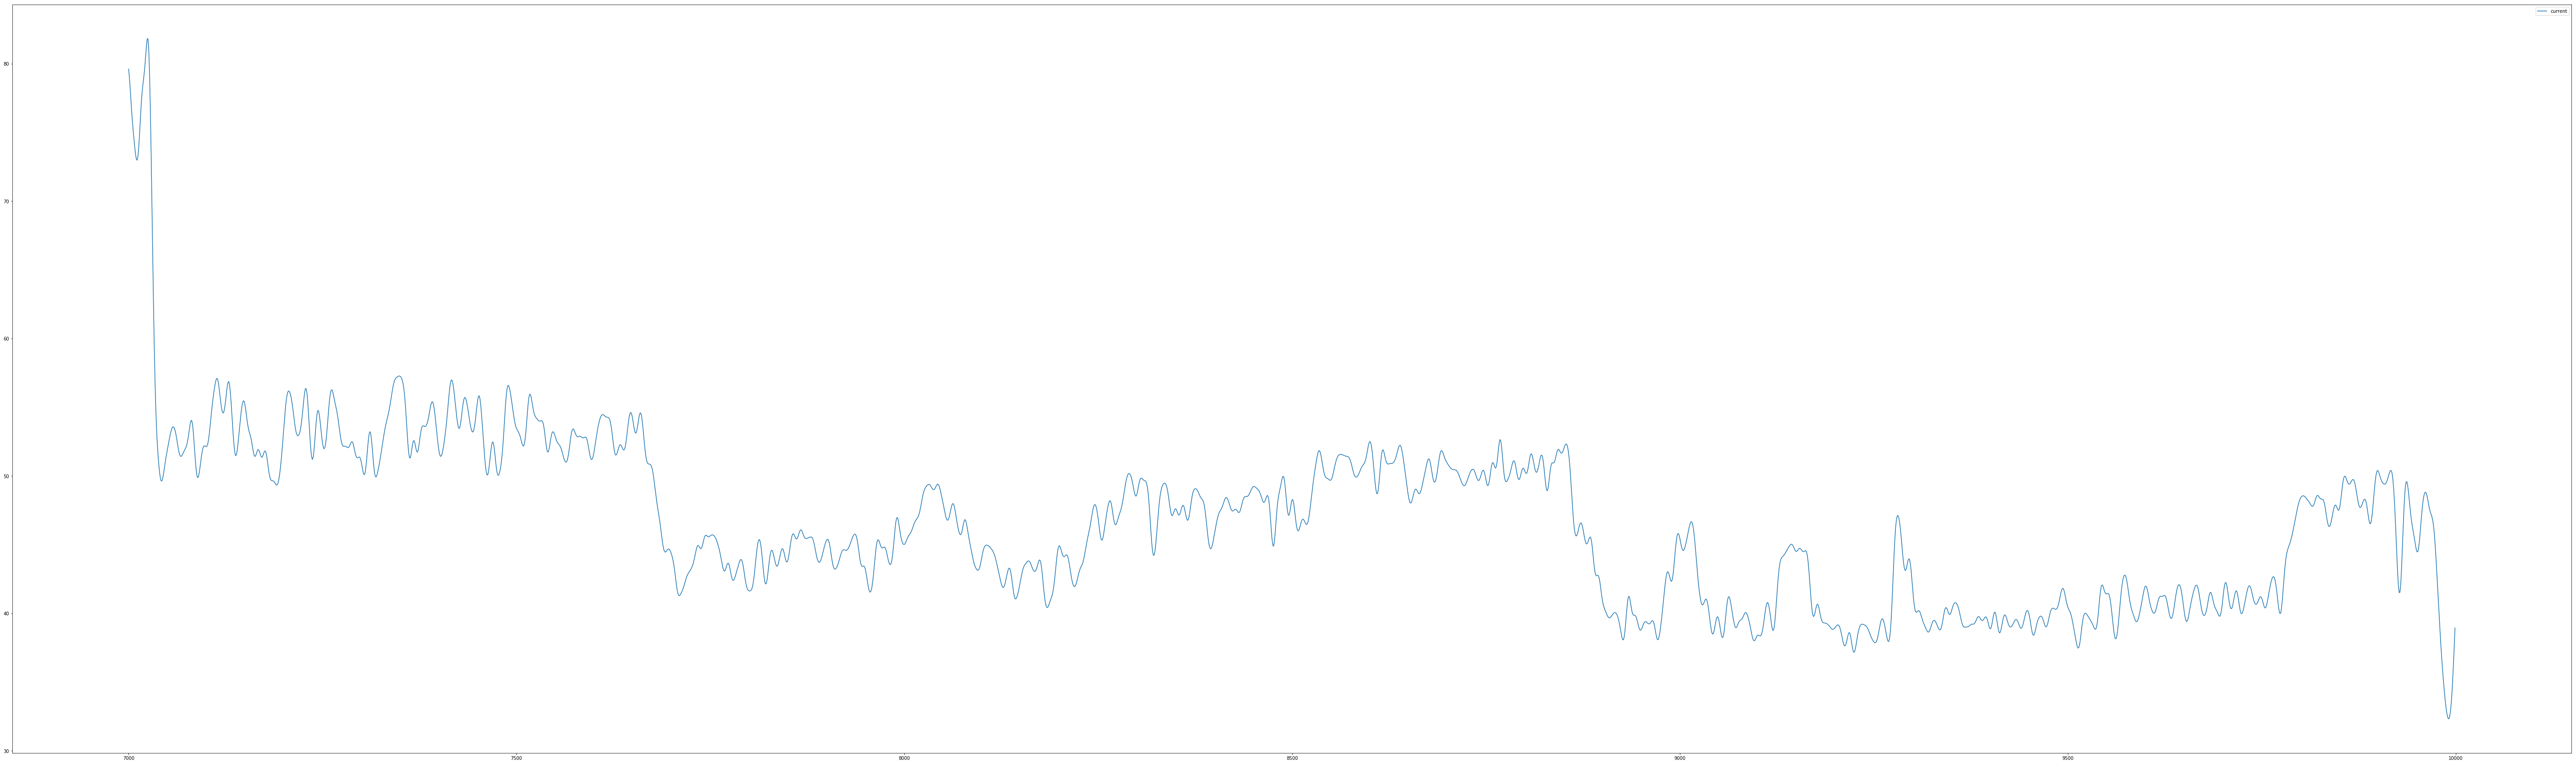

In [119]:
ts[7000:10000].plot(figsize=(100, 30));

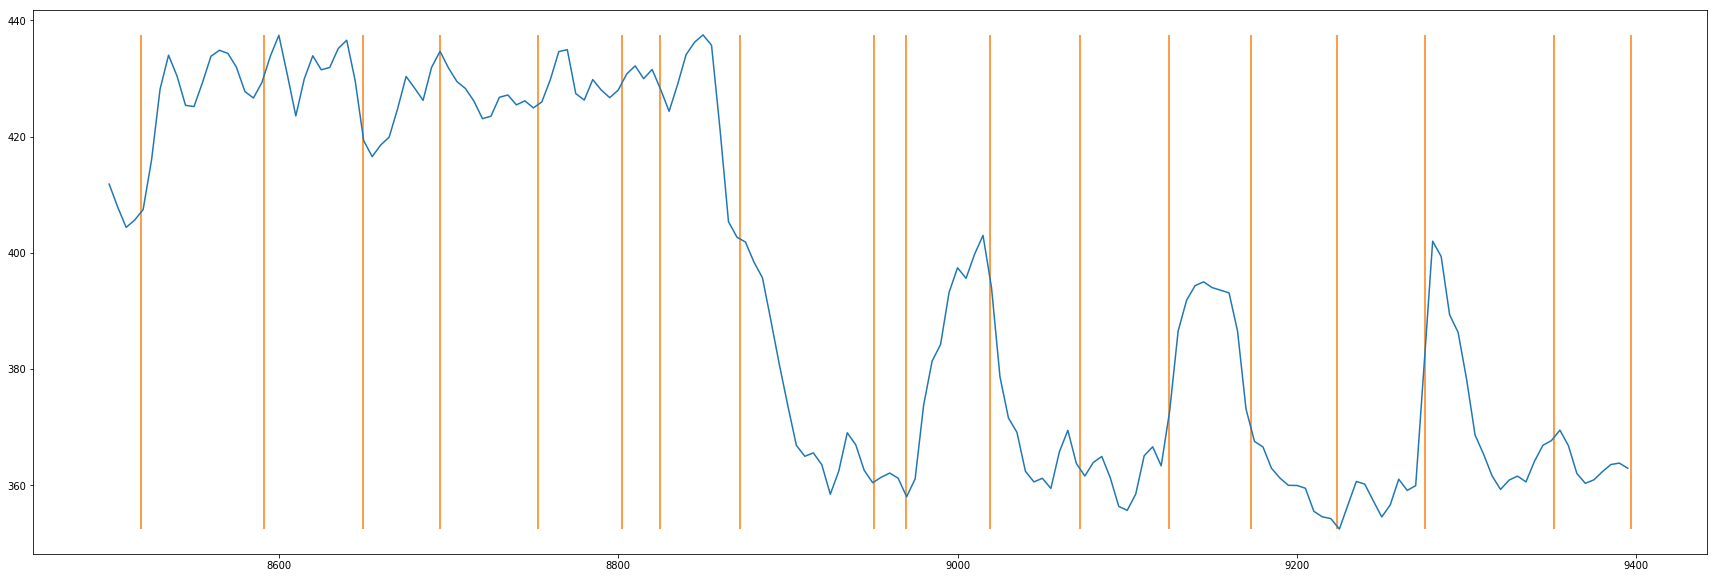

In [198]:
cutoff = 100
vl_r = [i[0] for i in test_r if i[1] < cutoff]
#vs_r = [i[1] for i in test_r if (i[1] < cutoff and sp.stats.ttest_ind_from_stats(i[2][0],i[2][1],20, i[3][0],i[3][1],20).pvalue < pc)]
plt.figure(figsize=(30, 10))
ps = tss[850*2:940*2]
plt.plot(ps)
plt.vlines(vl_r, ps.min(), ps.max(), color='C1');

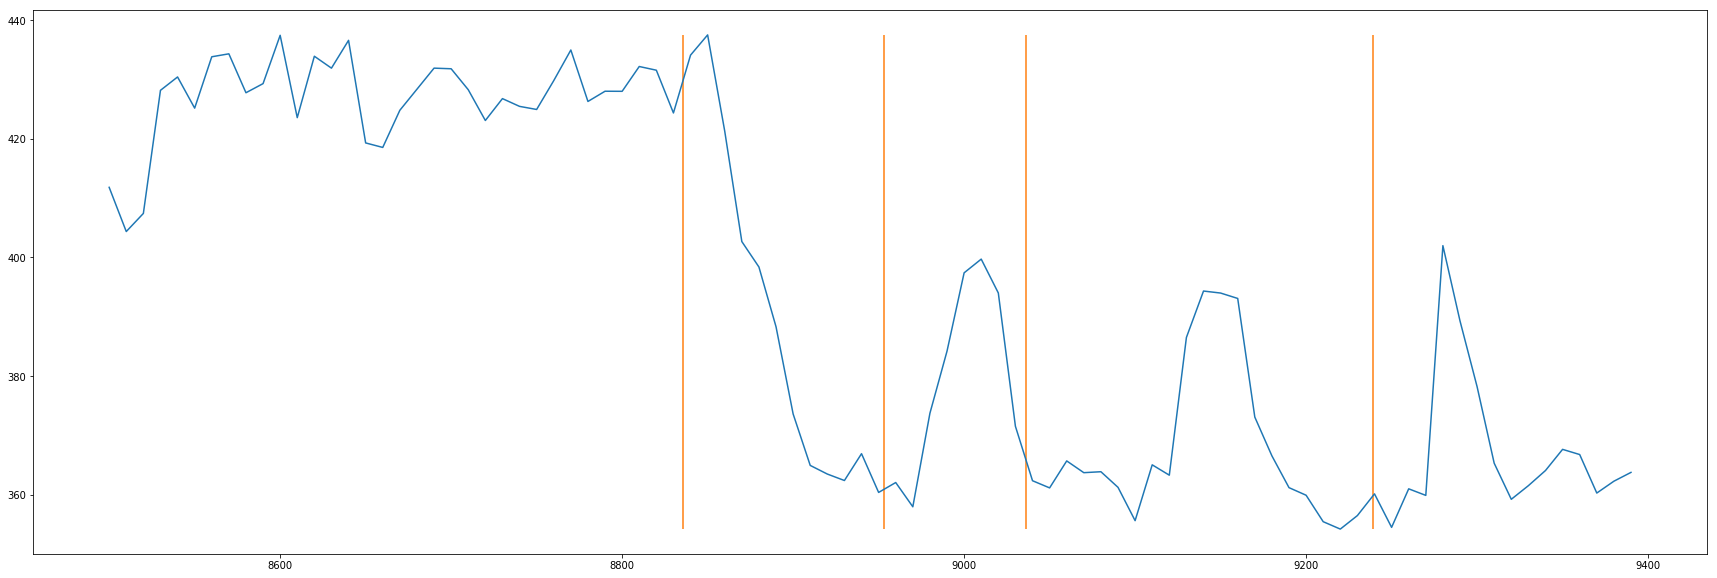

In [191]:
cutoff = 50; pc = 0.9
vl_r = [i[0] for i in test_r if (i[1] < cutoff and sp.stats.ttest_ind_from_stats(i[2][0],i[2][1],size_r//2, i[3][0],i[3][1],size_r//2).pvalue < pc)]
vs_r = [i[1] for i in test_r if (i[1] < cutoff and sp.stats.ttest_ind_from_stats(i[2][0],i[2][1],size_r//2, i[3][0],i[3][1],size_r//2).pvalue < pc)]
plt.figure(figsize=(30, 10))
ps = tss[850:940]
plt.plot(ps)
plt.vlines(vl_r, ps.min(), ps.max(), color='C1')
for i in [i for i in test_r if i[1] < (i[1] < cutoff and sp.stats.ttest_ind_from_stats(i[2][0],i[2][1],size_r//2, i[3][0],i[3][1],size_r//2).pvalue < pc)]:
    plt.fill_betweenx(y=[int(ps.min()), int(ps.max())], x1=i[0] - i[1], x2=i[0] + i[1], alpha=0.5, color='C1');

In [159]:
[sp.stats.ttest_ind_from_stats(i[2][0],i[2][1],size_r//2, i[3][0],i[3][1],size_r//2).pvalue for i in test_r]

[0.8995973063559213,
 0.7755775263095552,
 0.6412031057266763,
 0.8779162106738947,
 0.6750919884462444,
 0.8141480915558388,
 0.9527898616418452,
 0.9086834672840618,
 0.7524907875780703,
 0.9468112466013817,
 0.9226671643104427,
 0.8313074820473123,
 0.5546061705745258,
 0.8516626219744222,
 0.9950917040188862,
 0.8365308099901085,
 0.9942291757165143,
 0.6091155500233182,
 0.8662026777046739,
 0.69729720391503,
 0.9628256917141375,
 0.7240359148937173,
 0.43682823025757844,
 0.7974999122177059,
 0.9040480568297677,
 0.716590293698256,
 0.8452604587060694,
 0.6911157352441025,
 0.8366359794006621,
 0.9940319708935414]

In [135]:
[i[1] for i in test_r]

[2.8167179482511204,
 31.277816020304236,
 31.508093801434576,
 30.358174249285806,
 29.743625262398663,
 27.663416274928878,
 30.576422289077577,
 32.0637325299161,
 34.124952747220036,
 30.076238129127784,
 30.008915341944636,
 30.534259038005164,
 2.717046880346381,
 2.809377155171587,
 31.297661154629427,
 32.149757386331856,
 29.56263171218016,
 27.11402669744942,
 29.613762742177833,
 31.56554203162049,
 28.64142443646963,
 29.30772082574829,
 31.491157092110797,
 30.38650646257315,
 3.021485561772553,
 30.385447894510293,
 30.664342484390563,
 30.093267934872074,
 31.313875119505727,
 26.341042001978582,
 30.944715219242198,
 30.13056743159677,
 31.86237504879384,
 31.19480315292918,
 28.290899596866833,
 32.96099057977475,
 2.8433859657105995,
 2.9258236019965387,
 30.623544761343354,
 2.6424420523447623,
 2.8183284052785615,
 27.568967041766367,
 3.0322227820527963,
 2.8857408061016154,
 2.8003169463473236,
 28.412859764550277,
 27.660729834912168,
 30.032074416363585,
 28.449